In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Data Collection and Analysis

In [5]:
customers = pd.read_csv(r'D:\z\Zeotap\Customers - Customers.csv')
products = pd.read_csv(r'D:\z\Zeotap\Products - Products.csv')
transactions = pd.read_csv(r'D:\z\Zeotap\Transactions - Transactions.csv')

In [7]:
customers.head(5)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [8]:
products.head(5)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [9]:
transactions.head(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [11]:
print(customers.info())
print('_______________________________________________')
print(products.info())
print('_______________________________________________')
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
_______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
_______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (tota

In [12]:
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [13]:
transactions['TotalValue'].fillna(transactions['TotalValue'].mean(), inplace=True)

In [14]:
# convert date to datetime column
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [16]:
# check for dublicate values
print(customers.duplicated().sum())
print(products.duplicated().sum())
print(transactions.duplicated().sum())

0
0
0


In [20]:
# check categorical values
def get_categorical_cols(df):
  """
  Returns a list of categorical column names from a Pandas DataFrame.

  Args:
    df: The input DataFrame.

  Returns:
    A list of strings representing the categorical column names.
  """
  categorical_cols = []
  for col in df.columns:
      if df[col].dtype == 'object':
          categorical_cols.append(col)
  return categorical_cols


categorical_columns = get_categorical_cols(customers)
print(categorical_columns)
categorical_columns = get_categorical_cols(products)
print(categorical_columns)
categorical_columns = get_categorical_cols(transactions)
print(categorical_columns)


['CustomerID', 'CustomerName', 'Region']
['ProductID', 'ProductName', 'Category']
['TransactionID', 'CustomerID', 'ProductID']


Merge the dataset

In [21]:
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')
print(merged_data.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00761      C0199      P022 2024-10-01 05:57:09         4   
2        T00626      C0199      P079 2024-08-17 12:06:08         2   
3        T00963      C0199      P008 2024-10-26 00:01:58         2   
4        T00112      C0146      P067 2024-05-27 22:23:54         1   

   TotalValue   Price     CustomerName  Region SignupDate  
0      300.68  300.68   Andrea Jenkins  Europe 2022-12-03  
1      550.16  137.54   Andrea Jenkins  Europe 2022-12-03  
2      834.74  417.37   Andrea Jenkins  Europe 2022-12-03  
3      293.70  146.85   Andrea Jenkins  Europe 2022-12-03  
4      300.68  300.68  Brittany Harvey    Asia 2024-09-04  


In [22]:
final_data = pd.merge(merged_data, products, on='ProductID', how='inner')
print(final_data.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36   300.68  Travis Campbell  South America 2024-04-11   
4      902.04   300.68    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker  Electronic

In [24]:
final_data.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64

In [25]:
# check categorical values
def get_categorical_cols(df):
  """
  Returns a list of categorical column names from a Pandas DataFrame.

  Args:
    df: The input DataFrame.

  Returns:
    A list of strings representing the categorical column names.
  """
  categorical_cols = []
  for col in df.columns:
      if df[col].dtype == 'object':
          categorical_cols.append(col)
  return categorical_cols


categorical_columns = get_categorical_cols(final_data)
print(categorical_columns)


['TransactionID', 'CustomerID', 'ProductID', 'CustomerName', 'Region', 'ProductName', 'Category']


In [26]:
final_data.head(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [27]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price_x          1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   object        
 11  Category         1000 non-null   object        
 12  Price_y          1000 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 101.7+ KB


In [ ]:
# change categorical feature to numerical value features
# mean/mode value for imputation



In [28]:
revenue_by_region = final_data.groupby('Region')['TotalValue'].sum()
print(revenue_by_region)

Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


In [29]:
top_customers = final_data.groupby('CustomerName')['TotalValue'].sum().sort_values(ascending=False).head(5)
print(top_customers)

CustomerName
Paul Parsons     10673.87
Bruce Rhodes      8040.39
Gerald Hines      7663.70
William Adams     7634.45
Aimee Taylor      7572.91
Name: TotalValue, dtype: float64


In [30]:
category_sales = final_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)
print(category_sales)

Category
Books          192147.47
Electronics    180783.50
Clothing       166170.66
Home Decor     150893.93
Name: TotalValue, dtype: float64


From the analysis, derive actionable insights are 

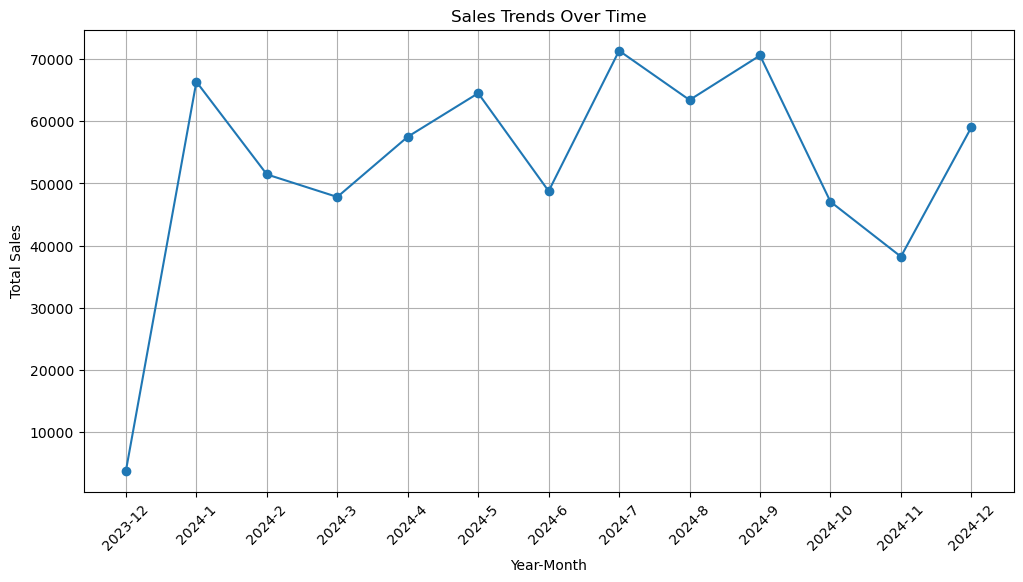

In [34]:
# Peak sales periods (e.g., months, years)
# Convert TransactionDate to datetime
final_data['TransactionDate'] = pd.to_datetime(final_data['TransactionDate'])

# Extract year and month
final_data['Year'] = final_data['TransactionDate'].dt.year
final_data['Month'] = final_data['TransactionDate'].dt.month

# Group by Year and Month
sales_by_year_month = final_data.groupby(['Year', 'Month'])['TotalValue'].sum().reset_index()

# Visualize sales trends
plt.figure(figsize=(12, 6))
plt.plot(sales_by_year_month['Year'].astype(str) + '-' + sales_by_year_month['Month'].astype(str), 
         sales_by_year_month['TotalValue'], marker='o')
plt.title('Sales Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [35]:
# The region contributing the highest revenue.
revenue_by_region = final_data.groupby('Region')['TotalValue'].sum()
print(revenue_by_region)

Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


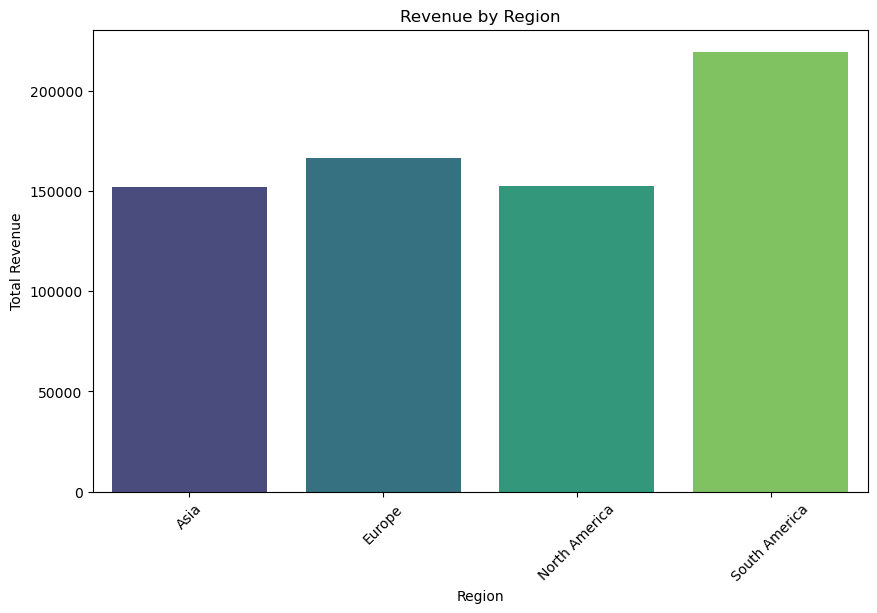

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_region.index, y=revenue_by_region.values, palette='viridis')

# Adding labels and title
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.title('Revenue by Region')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Products with the highest sales volume.
top_customers = final_data.groupby('CustomerName')['TotalValue'].sum().sort_values(ascending=False).head(5)
print(top_customers)

# Average customer spend.
# Total spend by each customer
customer_spend = final_data.groupby('CustomerName')['TotalValue'].sum().reset_index()
customer_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# Add the average spend for all customers
average_spend = customer_spend['TotalSpend'].mean()

print(f"Overall Average Customer Spend: ${average_spend:.2f}")

# Top 5 customers by spend
top_customers = customer_spend.sort_values(by='TotalSpend', ascending=False).head(5)
print("Top 5 Customers by Spend:")
print(top_customers)

CustomerName
Paul Parsons     10673.87
Bruce Rhodes      8040.39
Gerald Hines      7663.70
William Adams     7634.45
Aimee Taylor      7572.91
Name: TotalValue, dtype: float64
Overall Average Customer Spend: $3467.31
Top 5 Customers by Spend:
      CustomerName  TotalSpend
153   Paul Parsons    10673.87
29    Bruce Rhodes     8040.39
63    Gerald Hines     7663.70
196  William Adams     7634.45
2     Aimee Taylor     7572.91


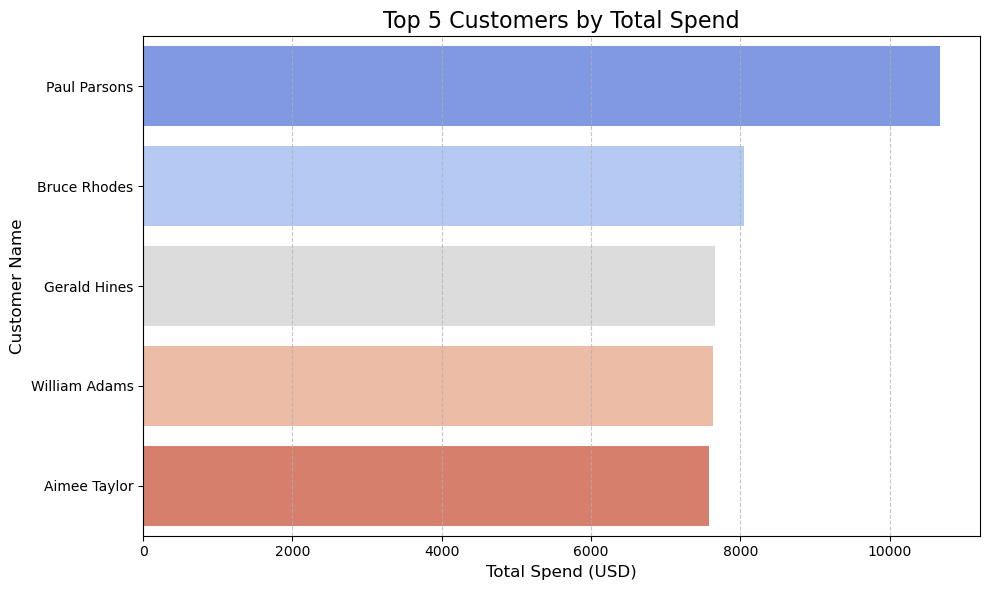

In [42]:
# Bar plot for top 5 customers by spend
plt.figure(figsize=(10, 6))
sns.barplot(x=top_customers['TotalSpend'], y=top_customers['CustomerName'], palette="coolwarm")
plt.title('Top 5 Customers by Total Spend', fontsize=16)
plt.xlabel('Total Spend (USD)', fontsize=12)
plt.ylabel('Customer Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

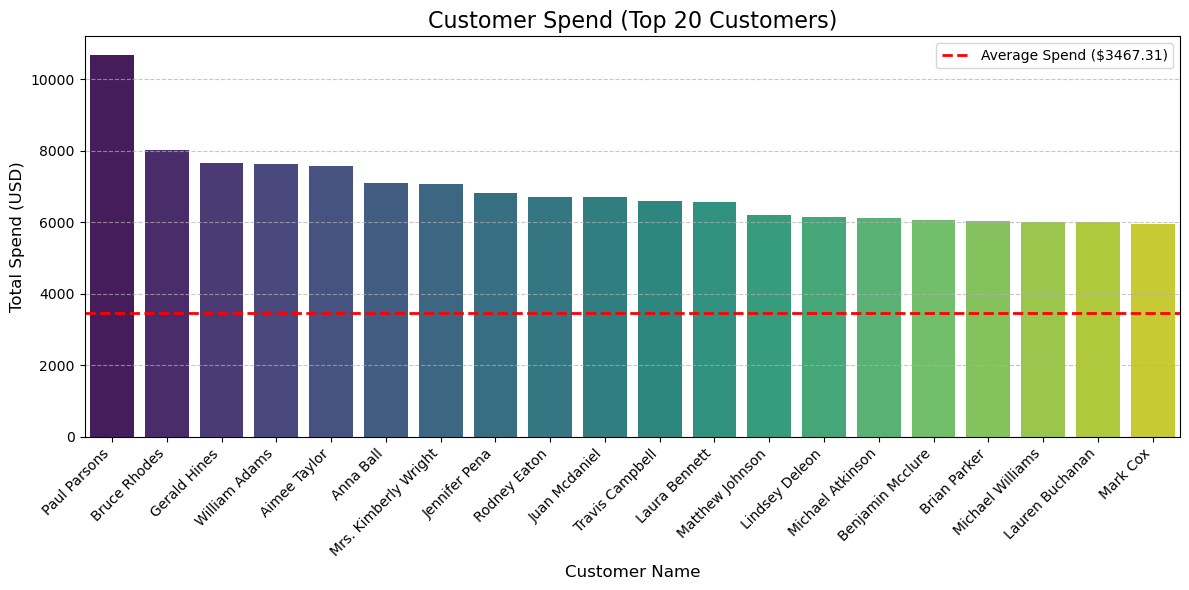

In [41]:
# Bar plot for customer spend with average spend line
plt.figure(figsize=(12, 6))
sns.barplot(x='CustomerName', y='TotalSpend', data=customer_spend.sort_values(by='TotalSpend', ascending=False).head(20), palette="viridis")
plt.axhline(average_spend, color='red', linestyle='--', linewidth=2, label=f'Average Spend (${average_spend:.2f})')
plt.title('Customer Spend (Top 20 Customers)', fontsize=16)
plt.xlabel('Customer Name', fontsize=12)
plt.ylabel('Total Spend (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
# Analyze product categories
category_sales = final_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)
print(category_sales)
 

Category
Books          192147.47
Electronics    180783.50
Clothing       166170.66
Home Decor     150893.93
Name: TotalValue, dtype: float64


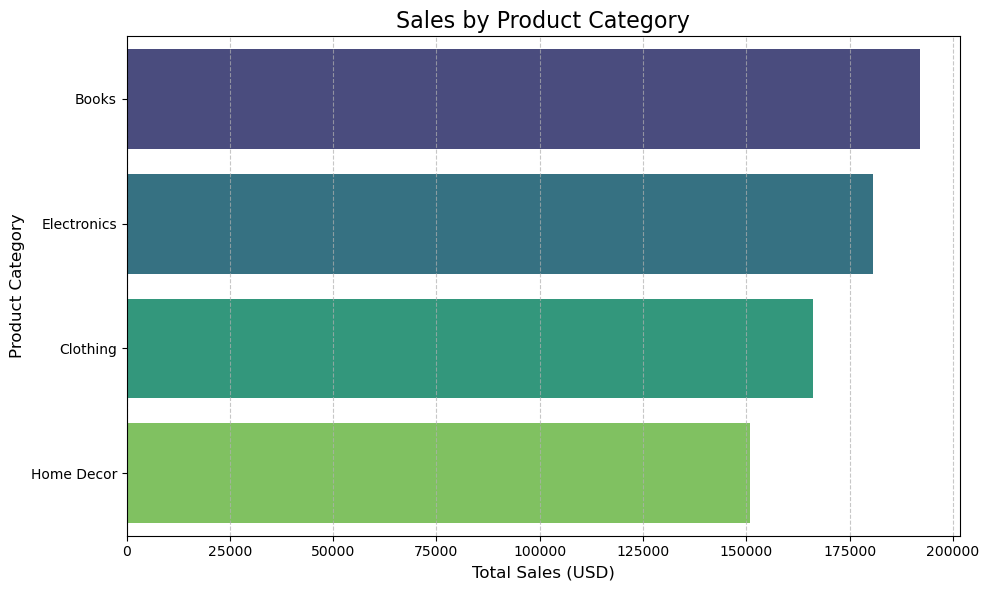

In [40]:
# Create a bar plot for product category sales
plt.figure(figsize=(10, 6))
sns.barplot(x=category_sales.values, y=category_sales.index, palette="viridis")
plt.title('Sales by Product Category', fontsize=16)
plt.xlabel('Total Sales (USD)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [43]:
# export the final dataset 

final_data.to_csv('Merged_Dataset.csv', index=False)